# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [3]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = 0.9
EPOCHS = 10
BATCH_SIZE = 32

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'close': close,
    'returns': log_returns,
    'vix': vix_close - vix_close.min(),
    'volatility': volatility - volatility.min()
})

X.dropna(inplace=True)
X.returns = X.returns / X.returns.max()
X.vix = X.vix / X.vix.max()
X.volatility = X.volatility / X.volatility.max()

X

,close,returns,vix,volatility
Date,,,,
2012-06-11,1308.930054,-0.141614,0.196057,0.132339
2012-06-12,1324.180054,0.129159,0.176071,0.136251
2012-06-13,1314.880005,-0.078588,0.205710,0.102126
2012-06-14,1329.099976,0.119940,0.170496,0.113723
2012-06-15,1342.839966,0.114679,0.162746,0.117266
...,...,...,...,...
2022-05-26,4057.840088,0.219530,0.249626,0.122096
2022-05-27,4158.240234,0.272527,0.225425,0.132580
2022-05-31,4132.149902,-0.070182,0.231815,0.152856


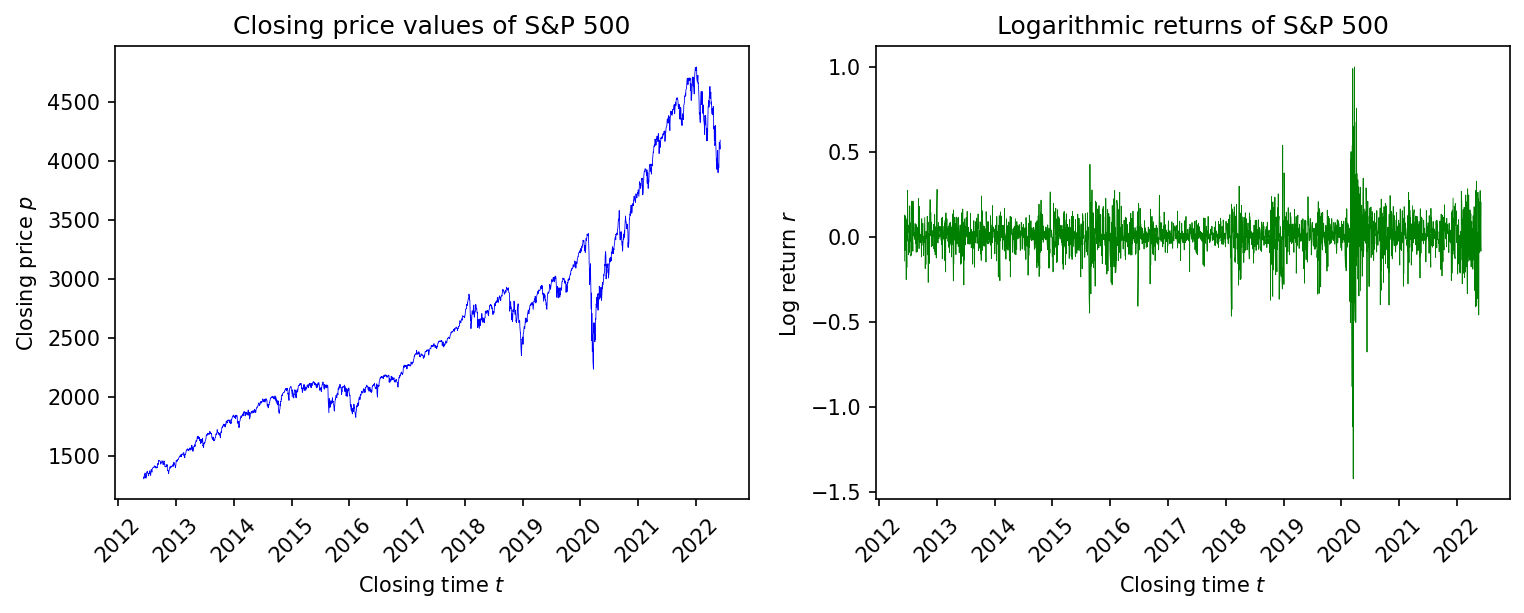

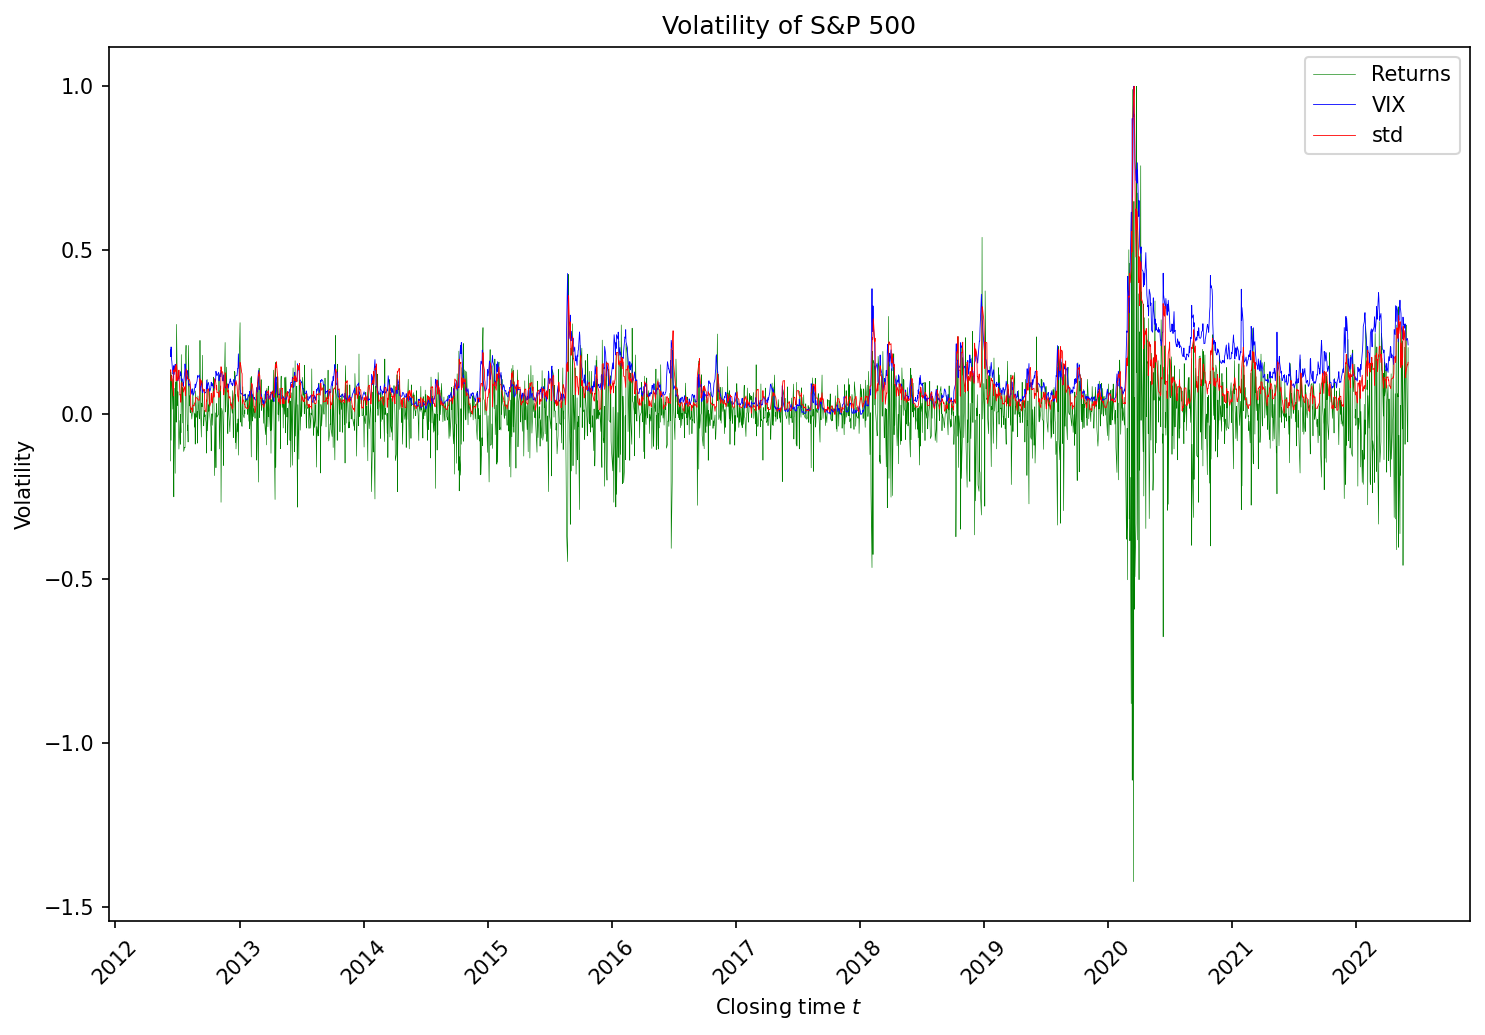

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.4, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.4, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.3, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.4, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.4, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build instances X as sequence of `LOOKBACK_WINDOW` vix values, and labels y as subsequent vix value
version = 'multivariate'

X_data = []
y_data = []

if version == 'univariate':

    print("Univariate data")

    for i in range(X.volatility.shape[0] - LOOKBACK_WINDOW):
        X_data.append(X.vix[i: i + LOOKBACK_WINDOW])
        y_data.append(X.vix[i + LOOKBACK_WINDOW])

    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, 2)
    y_data = np.array(y_data)
    y_data = np.expand_dims(y_data, 1)

elif version == 'multivariate':

    print("Multivariate data")

    X_mat = X.drop(['vix'], axis=1).values
    transformer = Normalizer().fit(X_mat)
    X_mat = transformer.transform(X_mat)
    y_vec = np.expand_dims(X.vix.values, 1)

    for i in range(X_mat.shape[0] - LOOKBACK_WINDOW):
        X_data.append(
            np.hstack(
                (X_mat[i: i + LOOKBACK_WINDOW], y_vec[i: i + LOOKBACK_WINDOW])
            )
        )

        y_data.append(y_vec[i + LOOKBACK_WINDOW])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

else:
    exit(1)

print(X_data.shape, y_data.shape)

Multivariate data
(2502, 10, 4) (2502, 1)


In [7]:
# split into training and testing data
train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:train_test_split]
y_train = y_data[:train_test_split]

X_test = X_data[train_test_split:]
y_test = y_data[train_test_split:]

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

(2251, 10, 4) (2251, 1) 
 (251, 10, 4) (251, 1)


In [8]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

rnn_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
gru_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
lstm_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
bidir_model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [9]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
bidir_history = bidir_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
71/71 [==============================] - 3s 21ms/step - loss: 0.3157 - mse: 0.5268
Epoch 2/10
71/71 [==============================] - 2s 21ms/step - loss: 0.1107 - mse: 0.0197
Epoch 3/10
71/71 [==============================] - 1s 21ms/step - loss: 0.0762 - mse: 0.0102
Epoch 4/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0681 - mse: 0.0073
Epoch 5/10
71/71 [==============================] - 1s 21ms/step - loss: 0.0535 - mse: 0.0050
Epoch 6/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0511 - mse: 0.0047
Epoch 7/10
71/71 [==============================] - 1s 21ms/step - loss: 0.0545 - mse: 0.0046
Epoch 8/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0442 - mse: 0.0033
Epoch 9/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0392 - mse: 0.0027
Epoch 10/10
71/71 [==============================] - 1s 21ms/step - loss: 0.0456 - mse: 0.0032
Epoch 1/10
71/71 [==============================] - 4s 5ms/

MSE:
    - RNN: 0.00943710754433708
    - GRU: 0.0007202077394617012
    - LSTM: 0.0007376180899457658
    - Bidirectional LSTM: 0.0007728118408479508


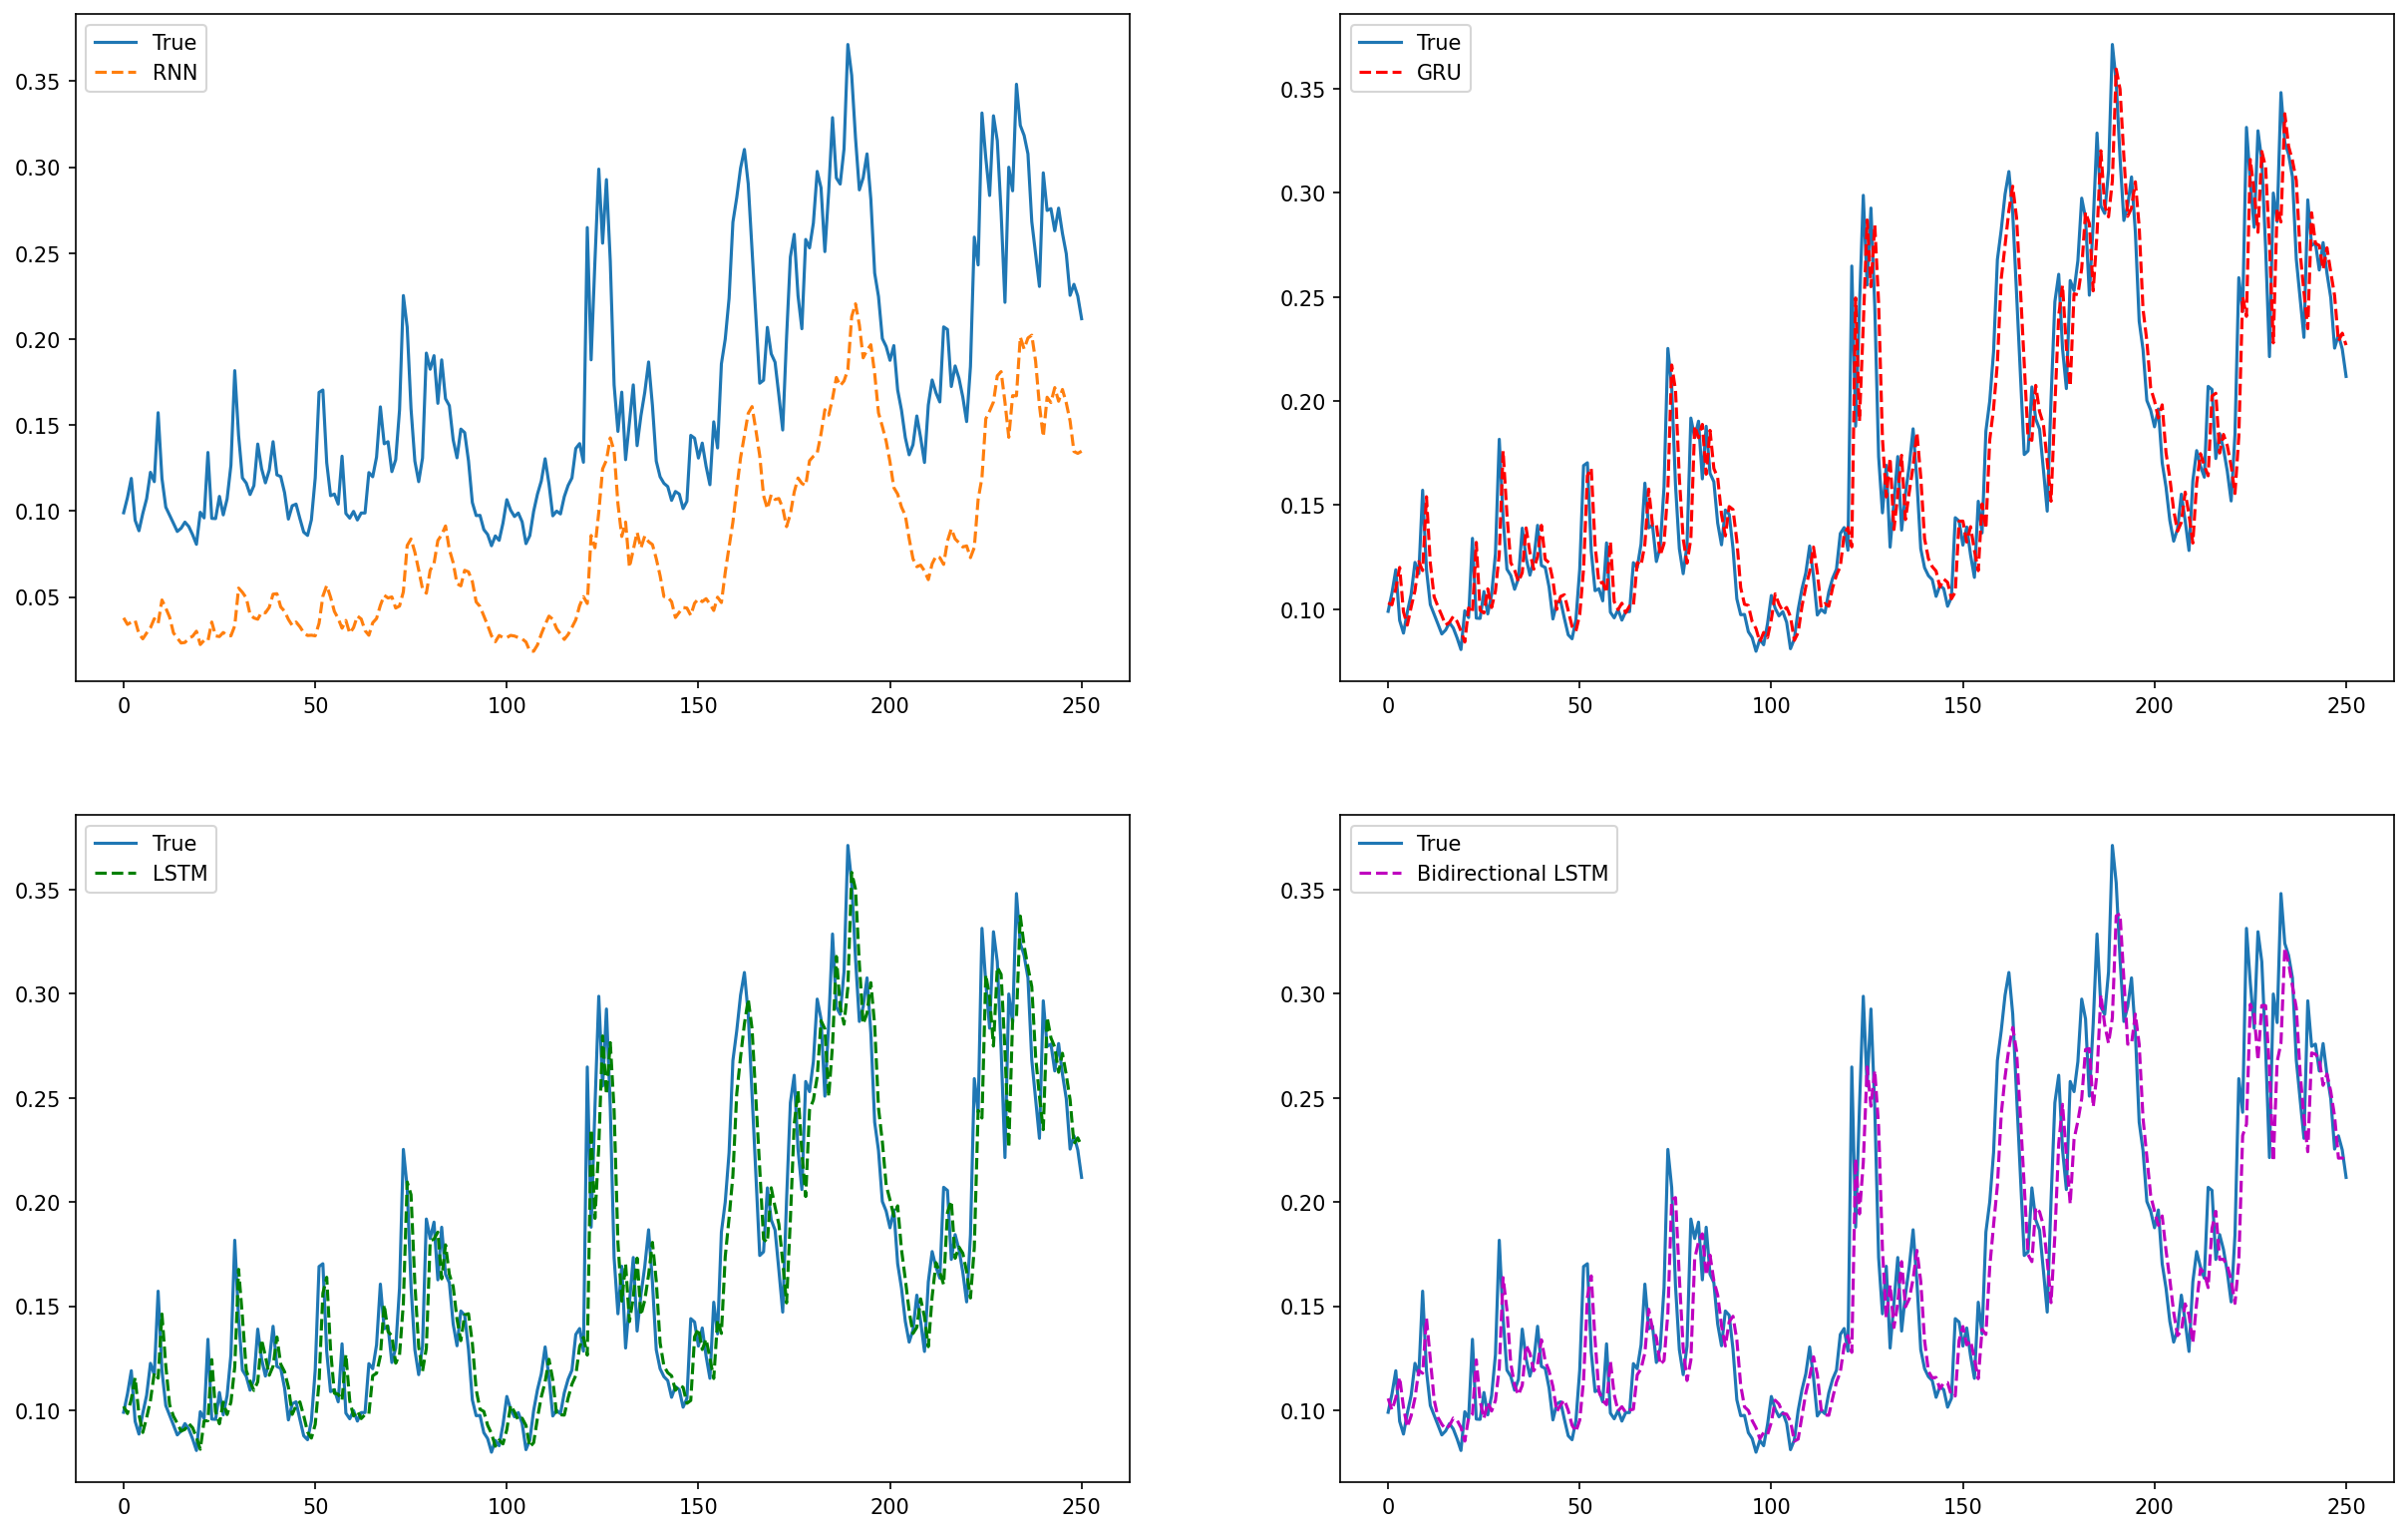

In [10]:
print("MSE:")
rnn_pred = rnn_model.predict(X_test)
rnn_mse = np.square(np.subtract(y_test, rnn_pred)).mean()
print(f"    - RNN: {rnn_mse}")

gru_pred = gru_model.predict(X_test)
gru_mse = np.square(np.subtract(y_test, gru_pred)).mean()
print(f"    - GRU: {gru_mse}")

lstm_pred = lstm_model.predict(X_test)
lstm_mse = np.square(np.subtract(y_test, lstm_pred)).mean()
print(f"    - LSTM: {lstm_mse}")

bidir_pred = bidir_model.predict(X_test)
bidir_mse = np.square(np.subtract(y_test, bidir_pred)).mean()
print(f"    - Bidirectional LSTM: {bidir_mse}")

fig, ax = plt.subplots(2, 2, figsize=(20, 13), dpi=150)

ax[0, 0].plot(y_test, label='True')
ax[0, 0].plot(rnn_pred, linestyle='--', label='RNN')
ax[0, 0].legend(loc=2)

ax[0, 1].plot(y_test, label='True')
ax[0, 1].plot(gru_pred, linestyle='--', color='r', label='GRU')
ax[0, 1].legend(loc=2)

ax[1, 0].plot(y_test, label='True')
ax[1, 0].plot(lstm_pred, linestyle='--', color='g', label='LSTM')
ax[1, 0].legend(loc=2)

ax[1, 1].plot(y_test, label='True')
ax[1, 1].plot(bidir_pred, linestyle='--', color='m', label='Bidirectional LSTM')
ax[1, 1].legend(loc=2)

plt.show()

**MSE**

*Univariate:*

- RNN: 0.08593333209299565
- GRU: 0.08628534089919165
- LSTM: 0.08416588001742062
- Bidirectional LSTM: 0.08573480099843421

*Multivariate:*

- RNN: 0.08878069443231994
- GRU: 0.08174636626249593
- LSTM: 0.0817325979890831
- Bidirectional LSTM: 0.08251407624835211